## Offset + normalized model results. 

This file is only different from notebooks/offset_imputation_files/bag_rev_forecast_on_offset.ipynb and notebooks/bag_rev_forecast.ipynb in that it documents model results on a dataset normalized by CPI

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from utilsforecast.plotting import plot_series
from utilsforecast.evaluation import evaluate
from utilsforecast.losses import *
from statsforecast import StatsForecast
from statsforecast.models import Naive, HistoricAverage, WindowAverage, SeasonalNaive
from statsforecast.models import AutoARIMA, AutoETS, AutoTheta
from utilsforecast.losses import mae, mape, rmse  

In [9]:
df_long = pd.read_csv(r"/home/rayan/Southwest_stuff/BaggageRevenueModel/data/reindexed_norm.csv")
df_long = df_long[['unique_id', 'ds', 'y']]
df_long['ds'] = pd.to_datetime(df_long['ds'])


df_long.head()

,unique_id,ds,y
0,Alaska,2015-03-31 23:59:59.999999999,25882.646985
1,Alaska,2015-06-30 23:59:59.999999999,32623.836913
2,Alaska,2015-09-30 23:59:59.999999999,36751.177099
3,Alaska,2015-12-31 23:59:59.999999999,26813.602177
4,Alaska,2016-03-31 23:59:59.999999999,32955.092602


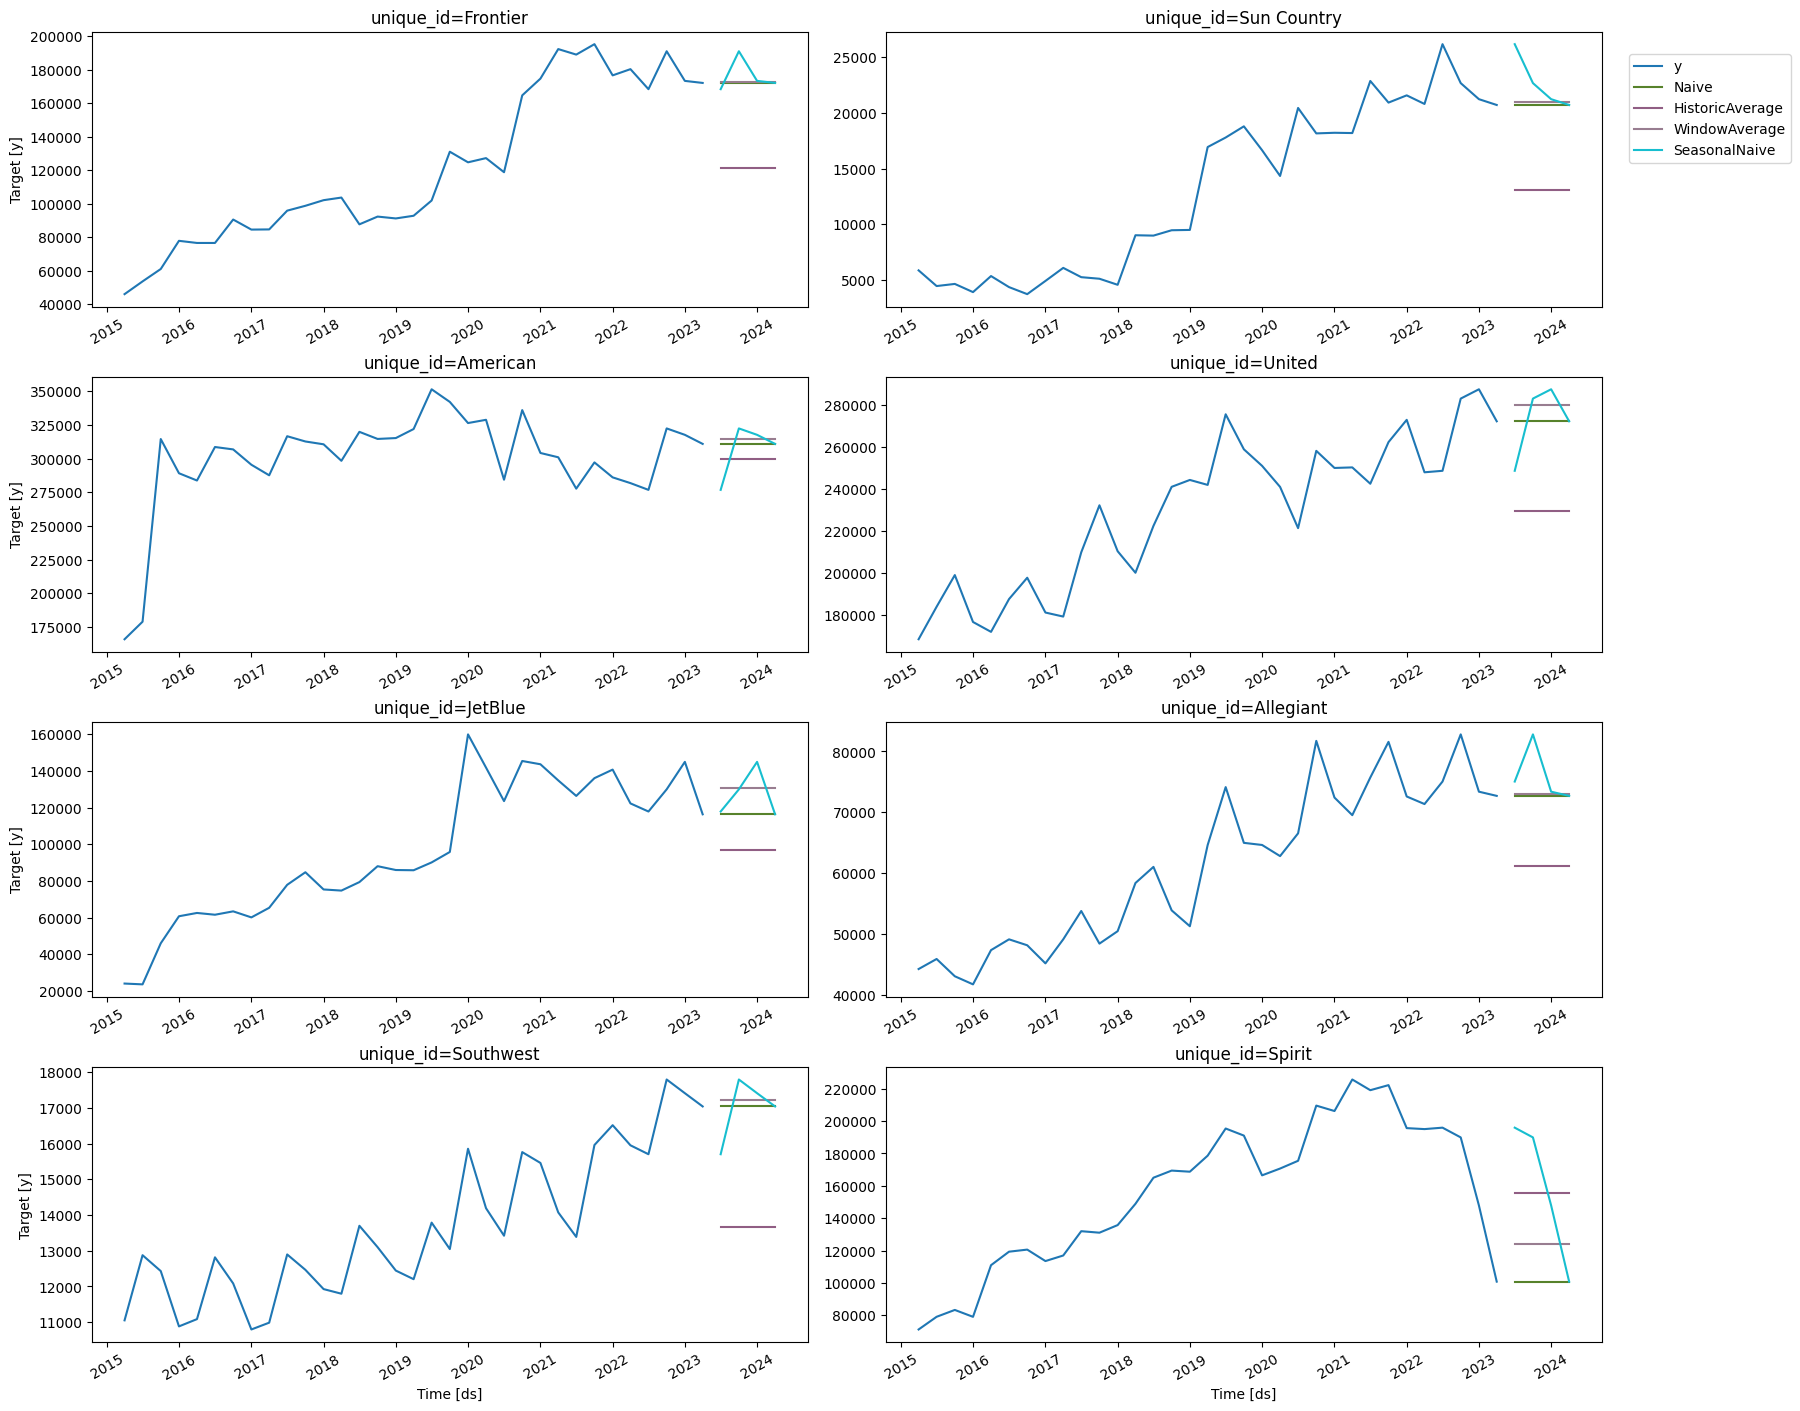

In [10]:
# Baseline models
horizon = 4 # forecasting a year ahead

models = [
    Naive(),
    HistoricAverage(),
    WindowAverage(window_size=2),
    SeasonalNaive(season_length=4)
]

sf = StatsForecast(models=models, freq='QE')
sf.fit(df=df_long)
preds = sf.predict(h=horizon)
preds.head()
plot_series(df=df_long, forecasts_df=preds)

In [11]:
# Evaluation of Baseline Models

test = df_long.groupby('unique_id').tail(horizon)
train = df_long.drop(test.index).reset_index(drop=True)

In [12]:
sf.fit(df=train)
preds = sf.predict(h=horizon)
eval_df = pd.merge(test, preds, 'left', ['unique_id', 'ds'])

In [13]:
evaluation = evaluate( df=eval_df, metrics=[mae, mape, rmse] )
evaluation

,unique_id,metric,Naive,HistoricAverage,WindowAverage,SeasonalNaive
0,Alaska,mae,13087.931977,25345.466298,9559.210757,7708.263346
1,Allegiant,mae,4636.923322,16913.000732,4013.764807,1007.499162
2,American,mae,27657.473399,19286.290934,26591.067217,21718.227809
3,Delta,mae,15057.923277,15267.034351,12307.882242,12240.654264
4,Frontier,mae,9478.372650,62728.641405,8549.857830,9106.458109
5,Hawaiian,mae,3280.117507,2511.678187,2687.486388,2482.141414
6,JetBlue,mae,10173.948565,34874.115189,10948.622275,6191.671882
7,Southwest,mae,1160.366504,3783.297394,1019.451399,1533.926616
8,Spirit,mae,36889.224249,34321.940838,37039.932225,49403.813525
9,Sun Country,mae,1940.727112,10943.800918,1747.525967,1372.181446


In [14]:
# ARIMA and SARIMA Models

unique_ids = df_long["unique_id"].unique().tolist()
small_train = train[train["unique_id"].isin(unique_ids)]
small_test = test[test["unique_id"].isin(unique_ids)]


models = [
    AutoARIMA(season_length=1, max_p=6, max_q=6, max_P=3, max_Q=3, alias="ARIMA"),
    AutoARIMA(season_length=4, max_p=6, max_q=6, max_P=3, max_Q=3, alias="SARIMA"),
    AutoETS(season_length=4, alias="ETS"),
    AutoTheta(season_length=4, alias="Theta"),
]

sf = StatsForecast(models=models, freq='QE')
sf.fit(df=small_train)
arima_preds = sf.predict(h=horizon)

arima_eval_df = pd.merge(test, arima_preds, 'left', ['ds', 'unique_id'])
arima_eval = evaluate( df=arima_eval_df, metrics=[mae, mape, rmse] )
arima_eval

,unique_id,metric,ARIMA,SARIMA,ETS,Theta
0,Alaska,mae,13087.931977,8949.330317,12435.148373,8888.478717
1,Allegiant,mae,5391.501695,5391.501695,5994.031303,5812.255435
2,American,mae,25978.905080,25978.905080,23807.947646,24718.177525
3,Delta,mae,12820.732714,11250.225801,15263.281652,15768.410270
4,Frontier,mae,16679.938323,16679.938323,19448.877918,15855.395667
5,Hawaiian,mae,3280.117507,2149.817226,2630.077830,2728.055095
6,JetBlue,mae,10173.948565,10173.948565,10173.948565,13859.440190
7,Southwest,mae,864.795321,864.795321,615.981759,1166.716534
8,Spirit,mae,47507.190667,47507.190667,66249.603940,47251.596364
9,Sun Country,mae,1940.727112,1940.727112,2792.956674,2670.045167


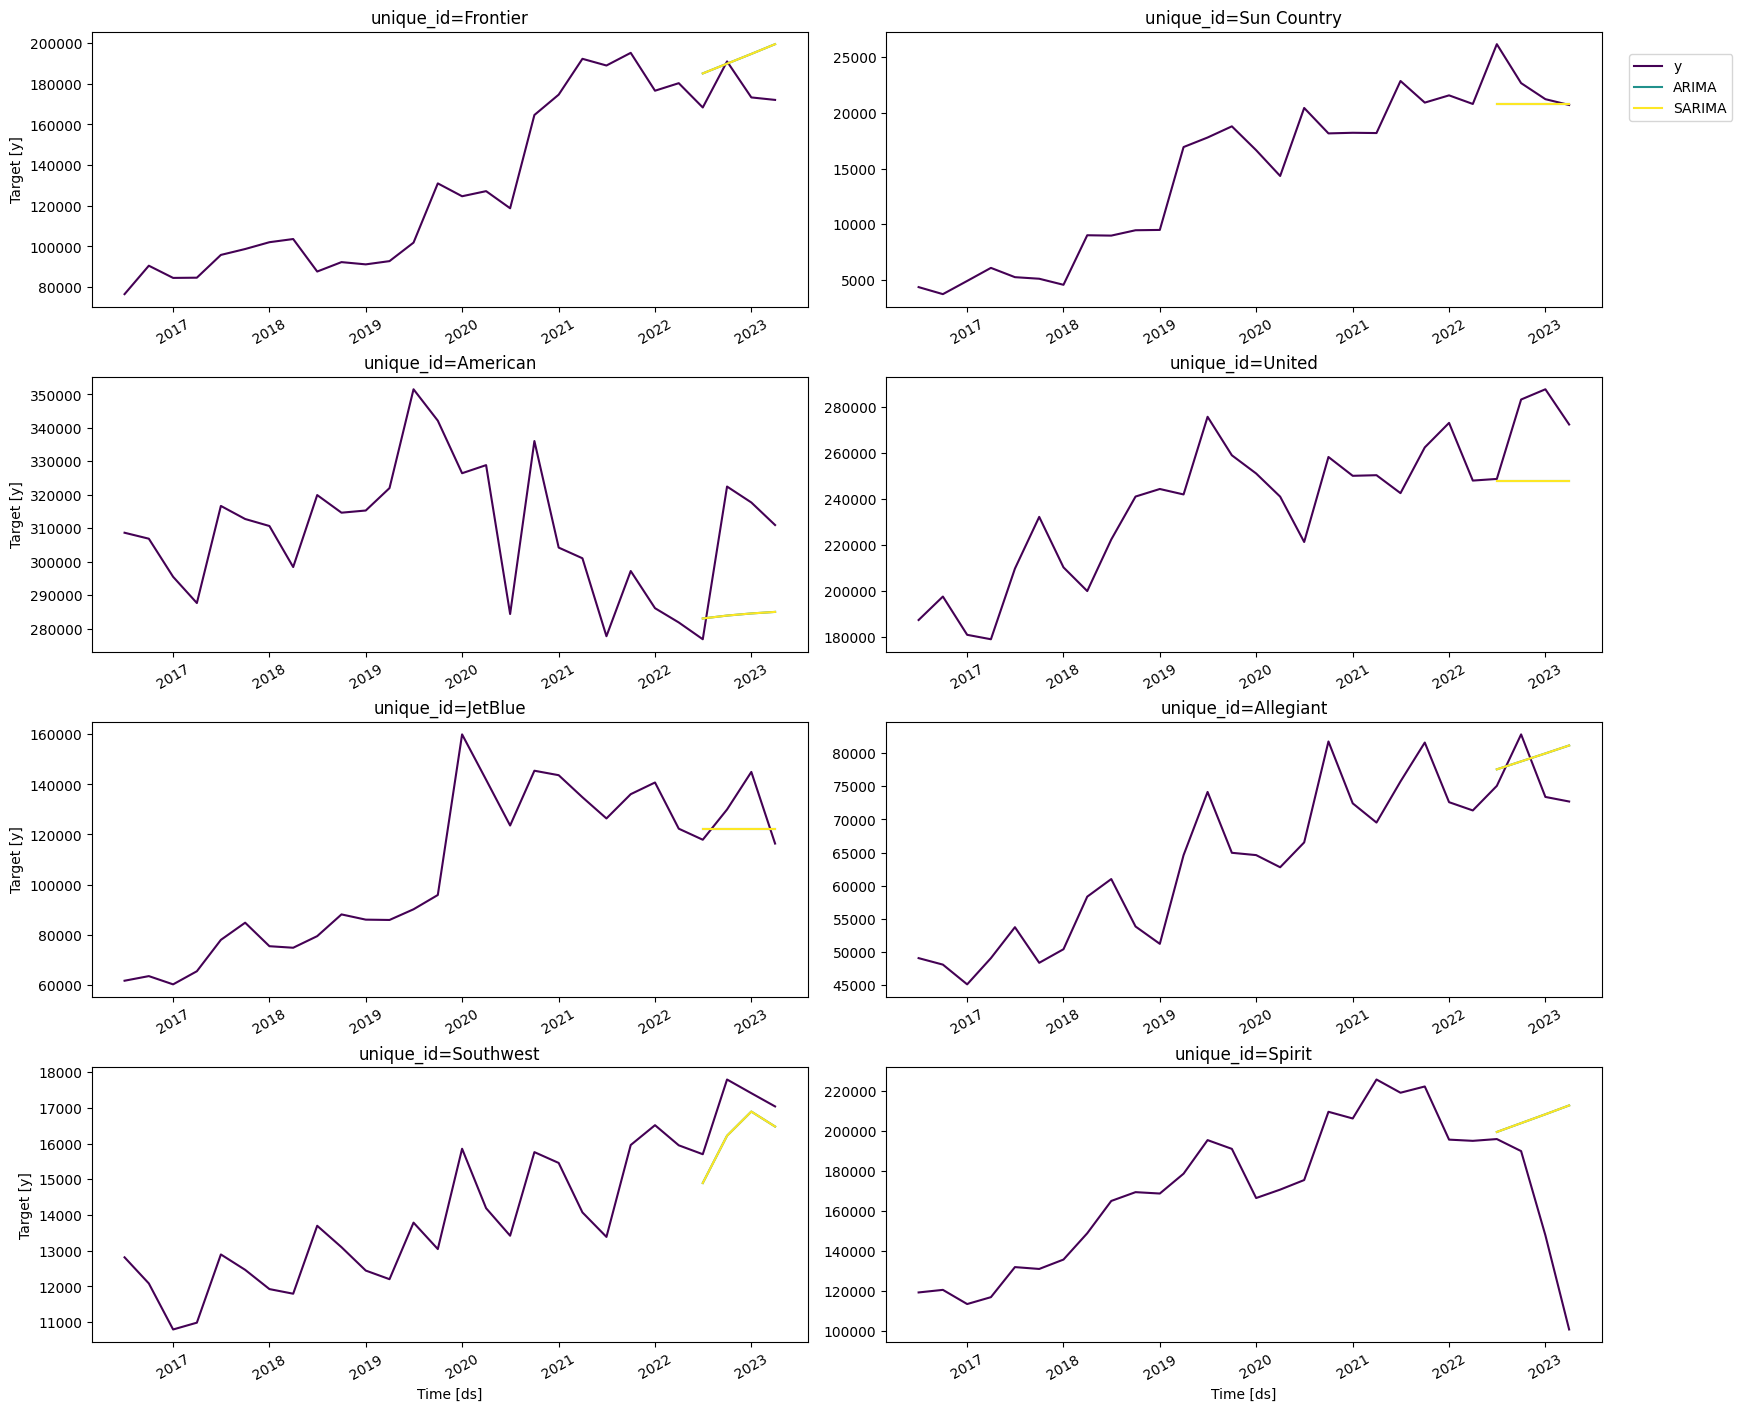

In [15]:
# plotting

ids_to_show = df_long['unique_id'].unique().tolist()
arima_plot = arima_preds[["unique_id","ds","ARIMA","SARIMA"]]

# Make the plot
plot_series(
    df=df_long,                          
    forecasts_df=arima_plot,       
    ids=ids_to_show,          
    max_insample_length=28,    
    palette="viridis"
)

In [16]:
## Cross-Validation
small_df = df_long[df_long["unique_id"].isin(unique_ids)]

models = [
    SeasonalNaive(season_length=4),
    AutoARIMA(seasonal=False, alias="ARIMA"),
    AutoARIMA(season_length=4, alias="SARIMA")
]

sf = StatsForecast(models=models,  freq="QE")
cv_df = sf.cross_validation(
    h=horizon,
    df=df_long,
    n_windows=4,
    step_size=horizon,
    refit=True
)

cv_df

,unique_id,ds,cutoff,y,SeasonalNaive,ARIMA,SARIMA
0,Alaska,2019-06-30 23:59:59.999999999,2019-03-31 23:59:59.999999999,85765.496928,79509.108366,70719.614873,94655.305473
1,Alaska,2019-09-30 23:59:59.999999999,2019-03-31 23:59:59.999999999,94289.000000,85276.845683,70719.614873,100423.042790
2,Alaska,2019-12-31 23:59:59.999999999,2019-03-31 23:59:59.999999999,66589.572166,70438.364062,70719.614873,85584.561170
3,Alaska,2020-03-31 23:59:59.999999999,2019-03-31 23:59:59.999999999,63584.617545,70719.614873,70719.614873,85865.811981
4,Alaska,2020-06-30 23:59:59.999999999,2020-03-31 23:59:59.999999999,58141.190847,85765.496928,63584.617545,78223.422592
...,...,...,...,...,...,...,...
171,United,2022-03-31 23:59:59.999999999,2021-03-31 23:59:59.999999999,248012.805202,250347.303043,250347.303043,250347.303043
172,United,2022-06-30 23:59:59.999999999,2022-03-31 23:59:59.999999999,248725.731439,242552.717302,248012.805202,248012.805202
173,United,2022-09-30 23:59:59.999999999,2022-03-31 23:59:59.999999999,283197.425470,262414.326134,248012.805202,248012.805202
174,United,2022-12-31 23:59:59.999999999,2022-03-31 23:59:59.999999999,287643.699648,273053.782402,248012.805202,248012.805202


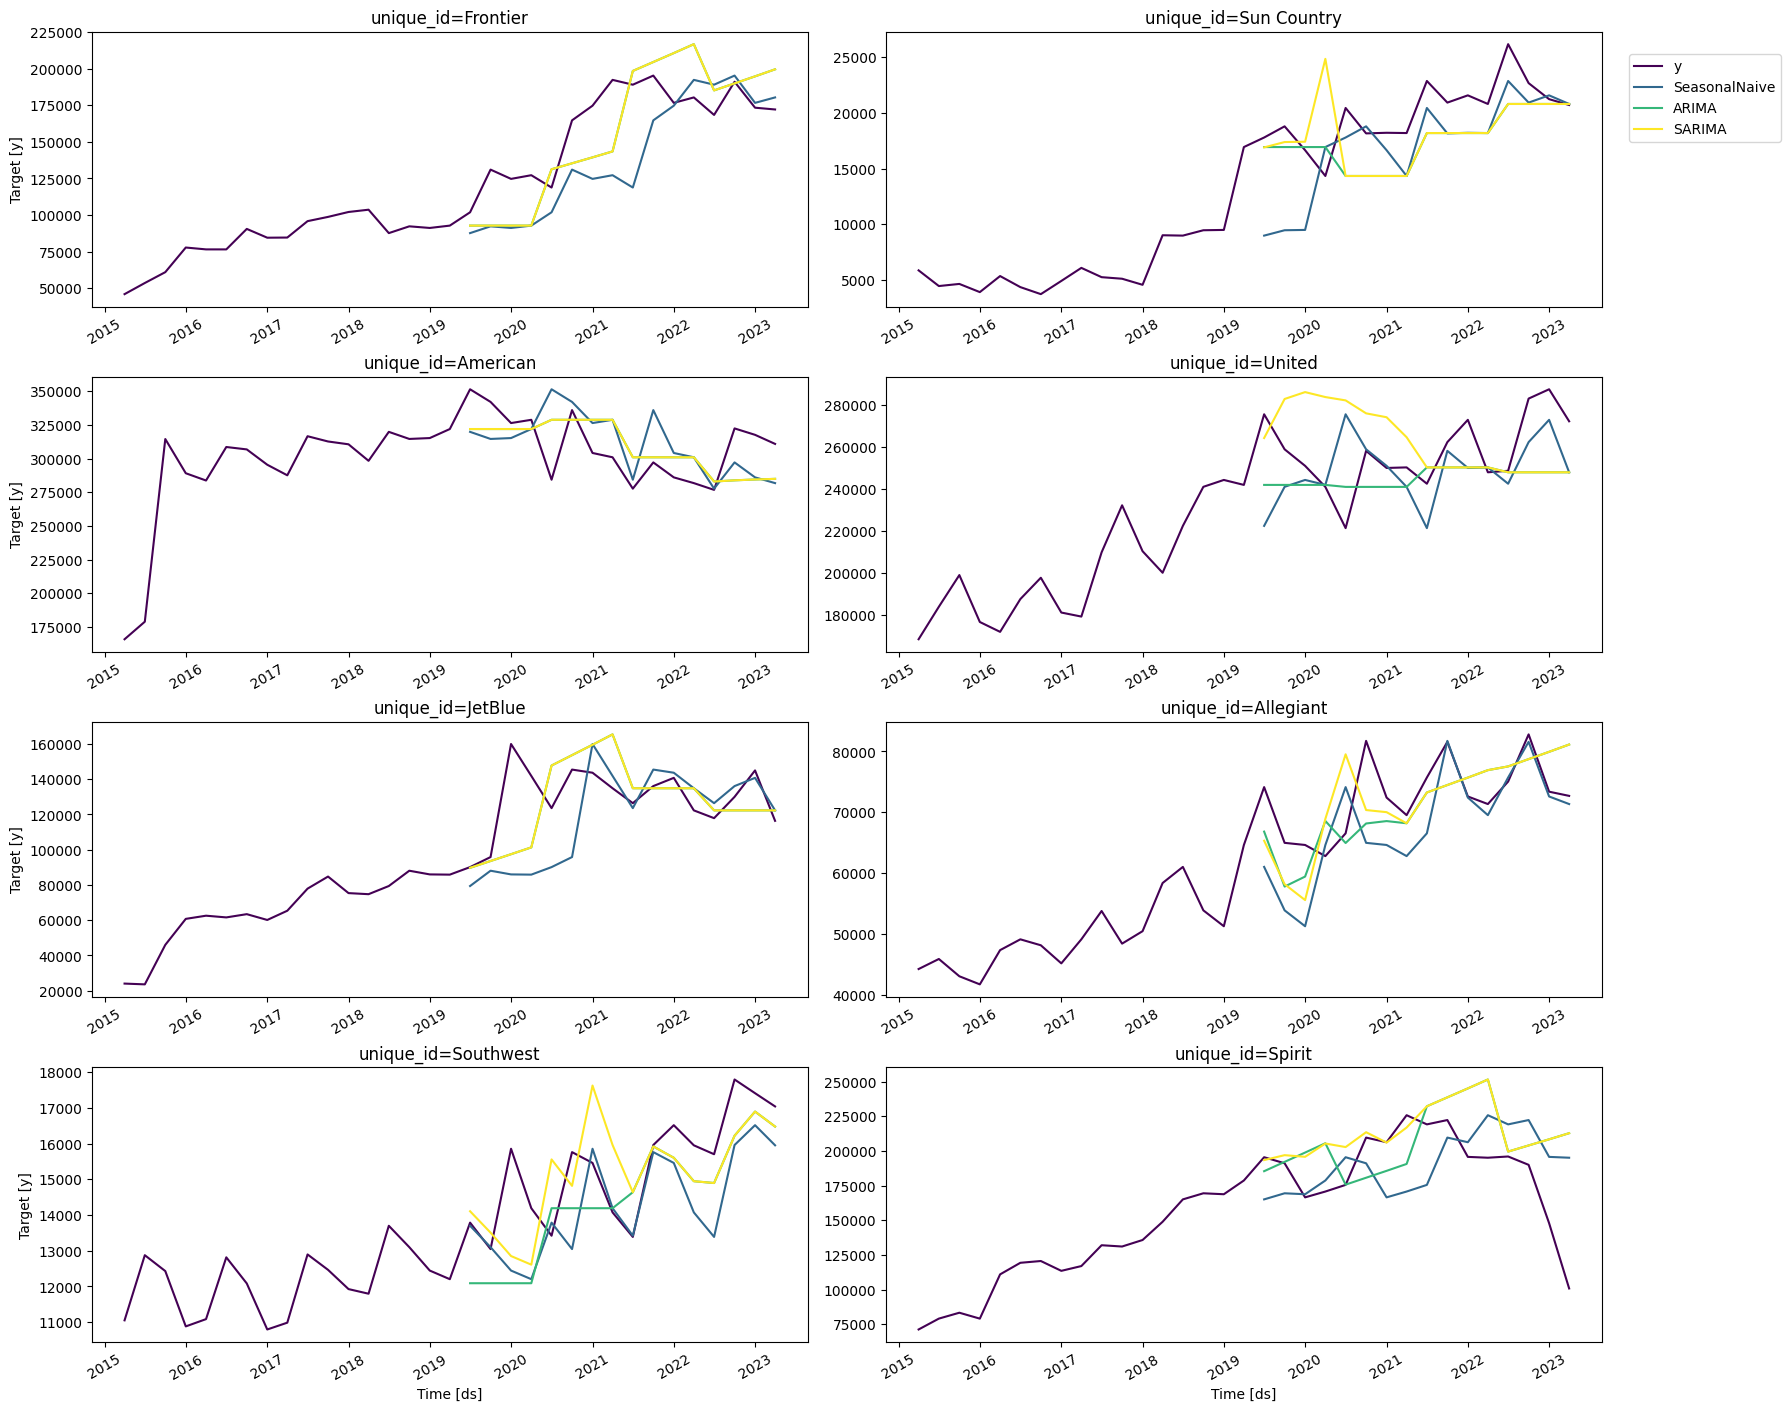

In [17]:
ids_to_show = df_long['unique_id'].unique().tolist()
arima_plot = arima_preds[["unique_id","ds","ARIMA","SARIMA"]]

# Make the plot
plot_series(
    df=small_df,                          
    forecasts_df=cv_df.drop(["y", "cutoff"], axis=1),      
    ids=ids_to_show,          
    max_insample_length=40,    
    palette="viridis"
)